In [1]:
!pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [2]:
#!pip install opacus# Install necessary libraries (if not installed)
!pip install plotly

In [3]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
from torch.optim.lr_scheduler import ExponentialLR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torchinfo import summary


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    # Convert to PyTorch tensor
    scan = torch.tensor(scan)
    return scan

In [5]:
source_dir = "/kaggle/input/data9data/Full_body_classes_9sub/"
class_dir = os.listdir(source_dir)

In [6]:
list_of_files = []
for cls in class_dir:
    class_path = os.listdir(source_dir+cls+'/')
    for file in class_path:
        list_of_files.append(source_dir+cls+'/'+file)

random.shuffle(list_of_files)


In [7]:
class_dir

['Upper arm movements',
 'Forearm movements',
 'Right leg movements',
 'Left leg movements']

In [8]:
np.array(read_nifti_file(list_of_files[0])).shape

(100, 100, 100)

In [9]:
dict_class = {cls: i for i, cls in enumerate(class_dir)}
dict_class

{'Upper arm movements': 0,
 'Forearm movements': 1,
 'Right leg movements': 2,
 'Left leg movements': 3}

In [10]:
num_classes = len(dict_class)
num_classes

4

In [11]:
dict_class[list_of_files[0].split('/')[-2]]

0

In [12]:
label = np.zeros((num_classes), dtype = np.float32)
label[dict_class[list_of_files[50].split('/')[-2]]] =1
label

array([0., 0., 1., 0.], dtype=float32)

In [13]:
class MRI(Dataset):
    """
    Custom Dataset class for loading and processing MRI images.

    This class inherits from `torch.utils.data.Dataset` and provides methods
    to efficiently load and prepare MRI images and their corresponding labels.

    Args:
        file_paths (list): List of file paths to the MRI image files.
        num_classes (int): Number of classes in the dataset.
        transform (callable, optional): A function to apply transformations
            to the loaded MRI data. Defaults to None.
    """

    def __init__(self, file_paths, num_classes, transform=None):
        """
        Initializes the MRI dataset.

        Args:
            file_paths (list): List of file paths to the MRI image files.
            num_classes (int): Number of classes in the dataset.
            transform (callable, optional): A function to apply transformations
                to the loaded MRI data. Defaults to None.
        """
        self.file_paths = file_paths
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset (number of data points).
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Retrieves a data point (MRI image and label) at a specific index.

        Args:
            idx (int): Index of the data point to retrieve.

        Returns:
            tuple: A tuple containing the preprocessed MRI image (tensor)
                and its corresponding label (one-hot encoded tensor).
        """
        path = self.file_paths[idx]

        # Replace this with your actual function to read NIfTI files
        data = read_nifti_file(path)  # Implement this function to read NIfTI data

        # Initialize a one-hot encoded label vector with zeros
        label = torch.zeros(self.num_classes, dtype=torch.float32)

        # Extract the class label from the file path using the provided dictionary
        class_index = dict_class[path.split('/')[-2]]
        label[class_index] = 1.0  # Set the corresponding class label to 1

        # Apply transformations if provided
        if self.transform:
            data = self.transform(data)

        # Add a channel dimension to the data tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        return data, label



In [14]:
train_sample = math.ceil(len(list_of_files)*0.8)

In [15]:
train_paths, val_paths = list_of_files[:train_sample], list_of_files[train_sample:]
val_sample = int(np.ceil(len(val_paths) * 0.5))
val_paths, test_paths = val_paths[:val_sample], val_paths[val_sample:]
print(f"Total train {len(train_paths)} Total val {len(val_paths)} Total test {len(test_paths)}")



Total train 2765 Total val 346 Total test 345


In [16]:
train_dataset = MRI(train_paths, num_classes, transform=None)
val_dataset = MRI(val_paths,num_classes, transform=None)
test_dataset = MRI(test_paths,num_classes, transform=None)

In [17]:
sample_idx = 0  
sample_data, sample_label = train_dataset[sample_idx]

print("Shape of sample data:", sample_data.shape)
print("Shape of sample label:", sample_label.shape)


Shape of sample data: torch.Size([1, 100, 100, 100])
Shape of sample label: torch.Size([4])


/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


In [18]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
for batch_data, batch_labels in train_loader:
    break  # Only get the first batch

# Print the shape of the first batch
print("Batch Data Shape:", batch_data.shape)
print("Batch Labels Shape:", batch_labels.shape)

/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


Batch Data Shape: torch.Size([32, 1, 100, 100, 100])
Batch Labels Shape: torch.Size([32, 4])


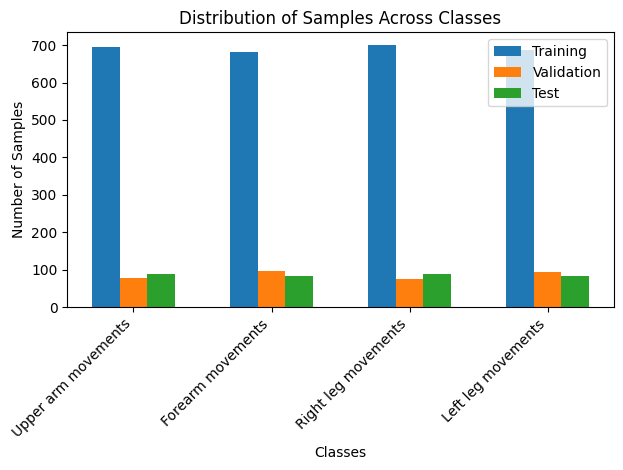

In [20]:
import matplotlib.pyplot as plt

# Get class counts for training, validation, and test sets
train_class_counts = {cls: 0 for cls in class_dir}
val_class_counts = {cls: 0 for cls in class_dir}
test_class_counts = {cls: 0 for cls in class_dir}

for path in train_paths:
    train_class_counts[path.split('/')[-2]] += 1

for path in val_paths:
    val_class_counts[path.split('/')[-2]] += 1

for path in test_paths:
    test_class_counts[path.split('/')[-2]] += 1

# Extract class names and counts
classes = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
val_counts = list(val_class_counts.values())
test_counts = list(test_class_counts.values())
np.savez("sample_distribution_data.npz",
         classes=classes,
         train_counts=train_counts,
         val_counts=val_counts,
         test_counts=test_counts)
# Plotting the bar chart
bar_width = 0.2
index = range(len(classes))

plt.bar(index, train_counts, width=bar_width, label='Training')
plt.bar([i + bar_width for i in index], val_counts, width=bar_width, label='Validation')
plt.bar([i + 2 * bar_width for i in index], test_counts, width=bar_width, label='Test')

plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples Across Classes')
plt.xticks([i + bar_width for i in index], classes, rotation=45, ha="right")
plt.legend()
plt.tight_layout() 
plt.show()

In [21]:
class ClassNameExtractor:
    def __init__(self):
        pass

    def extract_class_name(self, file_path):
        class_name = os.path.basename(os.path.dirname(file_path))
        return class_name

# Example usage:
# Assuming `train_paths` is a list of file paths
# train_paths = ["/kaggle/input/data9data/Full_body_classes_9sub/Left leg movements/volume_sub_07_run_05_25.nii"]
extractor = ClassNameExtractor()
class_name = extractor.extract_class_name(train_paths[5])
print("Class name:", class_name)


Class name: Forearm movements


Text(0.5, 1.0, 'Upper arm movements')

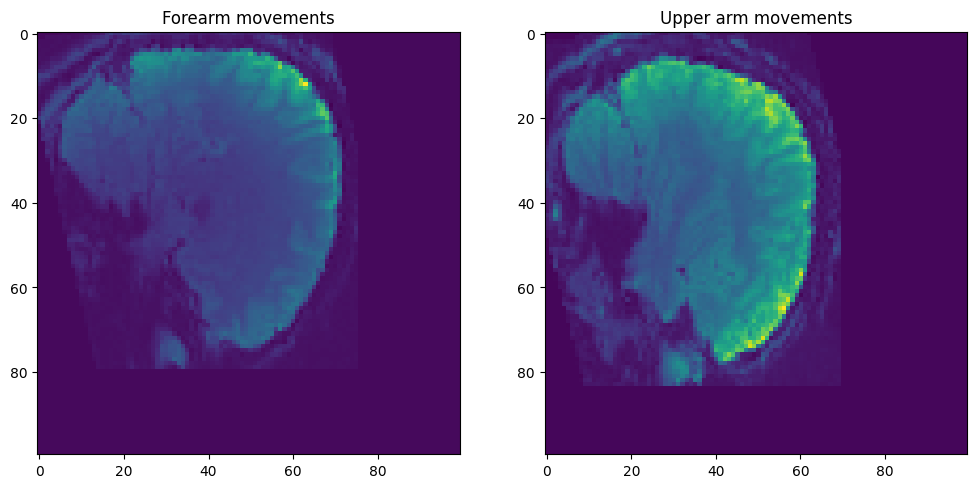

In [22]:
test_image1=read_nifti_file(train_paths[5])
test_image2=read_nifti_file(train_paths[0])

#test_mask=nib.load(all_masks[0]).get_data()
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image1[test_image1.shape[0]//2])
ax1.set_title(extractor.extract_class_name(train_paths[100]))
ax2.imshow(test_image2[test_image2.shape[0]//2])
ax2.set_title(extractor.extract_class_name(train_paths[0]))

**RandomNoiseRegularization** - not used. But tried


In [23]:
"""class RandomNoiseRegularization(nn.Module):
    def __init__(self, mean=0, std=0.1):
        super(RandomNoiseRegularization, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        noise = torch.randn_like(x) * self.std + self.mean
        return x + noise"""

'class RandomNoiseRegularization(nn.Module):\n    def __init__(self, mean=0, std=0.1):\n        super(RandomNoiseRegularization, self).__init__()\n        self.mean = mean\n        self.std = std\n\n    def forward(self, x):\n        noise = torch.randn_like(x) * self.std + self.mean\n        return x + noise'

In [24]:
class DropConnectRegularization(nn.Module):
    """DropConnect regularization layer.
    
    This layer implements a simplified version of DropConnect by applying a mask
    to the input tensor during training.
    
    Args:
        p: Dropout rate (between 0 and 1).
    """
    def __init__(self, p):
        super(DropConnectRegularization, self).__init__()
        self.p = p

    def forward(self, inputs):
        """
        Applies DropConnect regularization to the input tensor.
        
        Args:
            inputs: Input tensor.
        
        Returns:
            The output tensor after applying DropConnect.
        """
        if self.training:
            # Create a mask of the same shape as inputs
            noise_shape = inputs.size()
            random_tensor = torch.rand(noise_shape, dtype=inputs.dtype, device=inputs.device)
            drop_mask = (random_tensor > self.p).float()

            # Apply mask and scale activations
            scale = 1.0 / (1.0 - self.p)
            masked_inputs = drop_mask * inputs
            return masked_inputs * scale
        else:
            return inputs

In [25]:
class AttentionBlock3D(nn.Module):
    def __init__(self, channels, kernel_size=(3, 3, 3), stride=(1, 1, 1)):
        super(AttentionBlock3D, self).__init__()
        self.query_conv = nn.Conv3d(channels, channels // 8, kernel_size=kernel_size, stride=stride, padding=1)
        self.key_conv = nn.Conv3d(channels, channels // 8, kernel_size=kernel_size, stride=stride, padding=1)
        self.value_conv = nn.Conv3d(channels, channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, D, H, W = x.size()
        
        # Generate query, key, and value tensors
        query = self.query_conv(x).view(batch_size, -1, D * H * W).permute(0, 2, 1)  # (batch_size, D*H*W, channels//8)
        key = self.key_conv(x).view(batch_size, -1, D * H * W)  # (batch_size, channels//8, D*H*W)
        value = self.value_conv(x).view(batch_size, -1, D * H * W)  # (batch_size, channels, D*H*W)
        
        # Compute attention scores
        attention_scores = torch.bmm(query, key)  # (batch_size, D*H*W, D*H*W)
        attention_scores = attention_scores / (D * H * W) ** 0.5  # Scaling
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, D*H*W, D*H*W)
        
        # Apply attention weights to value
        attended_values = torch.bmm(value, attention_weights.permute(0, 2, 1))  # (batch_size, channels, D*H*W)
        attended_values = attended_values.view(batch_size, C, D, H, W)  # (batch_size, channels, D, H, W)
        
        # Combine attended values with the original input
        out = self.gamma * attended_values + x
        
        return out

In [26]:


class CNN3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super(CNN3D, self).__init__()

        self.instancenorm0 = nn.InstanceNorm3d(1, eps=1e-03)
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2))
        self.instancenorm1 = nn.InstanceNorm3d(32, eps=1e-03)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2))
        self.instancenorm2 = nn.InstanceNorm3d(64, eps=1e-03)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(20, 20, 20), stride=(1, 1, 1))
        self.instancenorm3 = nn.InstanceNorm3d(128, eps=1e-03)
        self.attention = AttentionBlock3D(128)
        self.global_avg_pooling = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128, num_classes)
        self.log_softmax = nn.Softmax(dim=1)
        self.dropconnect = DropConnectRegularization(p=0.17)

    def forward(self, x):
        # Initial normalization
        x = self.instancenorm0(x)
        
        # 3D CNN layers with Instance Normalization
        x = F.relu(self.instancenorm1(self.conv1(x)))
        x = F.relu(self.instancenorm2(self.conv2(x)))
        x = F.relu(self.instancenorm3(self.conv3(x)))
        
        # Global average pooling to reduce spatial dimensions
        x = self.global_avg_pooling(x)  # Shape: [batch_size, 128, 1, 1, 1]
        
        # Attention mechanism
        x = self.attention(x)  # Shape remains: [batch_size, 128, 1, 1, 1]
        
        # Remove singleton dimensions (spatial dims become trivial after pooling)
        x = x.view(x.size(0), 128)  # Shape: [batch_size, 128]
        
        # Create a sequence-like structure for Transformer
        x = x.unsqueeze(1)  # Shape: [batch_size, 1, 128] (sequence length = 1)
        x = x.permute(1, 0, 2)  # Shape: [seq_length, batch_size, d_model]
        
        # Transformer encoder
        x = self.transformer_encoder(x)  # Shape: [seq_length, batch_size, d_model]
        x = x.permute(1, 0, 2)  # Shape: [batch_size, seq_length, d_model]
        x = x.squeeze(1)  # Remove sequence dimension, final shape: [batch_size, d_model]
        
        # Fully connected layer, softmax, and DropConnect
        x = self.dropout(x)
        x = self.fc(x)
        x = self.log_softmax(x)
        x = self.dropconnect(x)
        
        return x


In [27]:
"""import torch
import torch.nn as nn
import torch.nn.functional as F

class DropConnectLinear(nn.Linear):
    def __init__(self, in_features, out_features, p=0.5, bias=True):
        super(DropConnectLinear, self).__init__(in_features, out_features, bias)
        self.p = p

    def forward(self, input):
        if self.training:
            mask = torch.bernoulli((1 - self.p) * torch.ones_like(self.weight)).to(self.weight.device)
            weight = self.weight * mask
            return F.linear(input, weight, self.bias)
        else:
            return F.linear(input, self.weight, self.bias)

class DropConnectConv3d(nn.Conv3d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, p=0.5, bias=True):
        super(DropConnectConv3d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.p = p

    def forward(self, input):
        if self.training:
            mask = torch.bernoulli((1 - self.p) * torch.ones_like(self.weight)).to(self.weight.device)
            weight = self.weight * mask
            bias = self.bias if self.bias is not None else None
            return F.conv3d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        else:
            return F.conv3d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

# Example usage in a model
class CNN3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=4, dropconnect_p=0.17):
        super(CNN3D, self).__init__()

        self.instancenorm0 = nn.InstanceNorm3d(1, eps=1e-03)
        self.conv1 = DropConnectConv3d(in_channels, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), p=dropconnect_p)
        self.instancenorm1 = nn.InstanceNorm3d(32, eps=1e-03)
        self.conv2 = DropConnectConv3d(32, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), p=dropconnect_p)
        self.instancenorm2 = nn.InstanceNorm3d(64, eps=1e-03)
        self.conv3 = DropConnectConv3d(64, 128, kernel_size=(20, 20, 20), stride=(1, 1, 1), p=dropconnect_p)
        self.instancenorm3 = nn.InstanceNorm3d(128, eps=1e-03)
        self.global_avg_pooling = nn.AdaptiveAvgPool3d(1)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

        self.dropout = nn.Dropout(0.25)
        self.fc = DropConnectLinear(128, num_classes, p=dropconnect_p)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.instancenorm0(x)
        x = F.leaky_relu(self.instancenorm1(self.conv1(x)))
        x = F.leaky_relu(self.instancenorm2(self.conv2(x)))
        x = F.leaky_relu(self.instancenorm3(self.conv3(x)))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)

        # Transformer Encoder expects input shape (seq_len, batch, d_model)
        x = x.unsqueeze(0)  # Add a sequence dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # Remove the sequence dimension

        x = self.dropout(x)
        x = self.fc(x)
        x = self.log_softmax(x)
        return x

"""

'import torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass DropConnectLinear(nn.Linear):\n    def __init__(self, in_features, out_features, p=0.5, bias=True):\n        super(DropConnectLinear, self).__init__(in_features, out_features, bias)\n        self.p = p\n\n    def forward(self, input):\n        if self.training:\n            mask = torch.bernoulli((1 - self.p) * torch.ones_like(self.weight)).to(self.weight.device)\n            weight = self.weight * mask\n            return F.linear(input, weight, self.bias)\n        else:\n            return F.linear(input, self.weight, self.bias)\n\nclass DropConnectConv3d(nn.Conv3d):\n    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, p=0.5, bias=True):\n        super(DropConnectConv3d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, bias=bias)\n        self.p = p\n\n    def forward(self, input):\n        if self.training:\n            mask = torch.bernoulli((1 - sel

In [28]:
"""class BasicBlock(nn.Module):
    def __init__(self, n_in, n_out, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(n_in, n_out, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm3d(n_out)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv3d(n_out, n_out, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm3d(n_out)

        self.relu2 = nn.ReLU(inplace = True) 
        if stride != 1 or n_out != n_in:
            self.shortcut = nn.Sequential(
                nn.Conv3d(n_in, n_out, kernel_size = 1, stride = stride),
                nn.BatchNorm3d(n_out))
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        if self.shortcut is not None:
            residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu2(out)
        return out
    
class DeepBrain(nn.Module):
    def __init__(self, block=BasicBlock, inplanes=1, planes=32, drop_out=True):
        super(DeepBrain, self).__init__()
        self.n_classes = num_classes
        
        self.preBlock = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(planes, eps=1e-03, momentum=0.99, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv3d(planes, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(32, eps=1e-03, momentum=0.99, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True))
        
        self.layer_1 = self._make_layer(block, 32, 64, 2)
        self.layer_2 = self._make_layer(block, 64, 64, 2, pooling=True)
        self.layer_3 = self._make_layer(block, 64, 128, 2, pooling=True)
        self.layer_4 = self._make_layer(block, 128, 64, 2, pooling=True)
        
        self.post_conv = nn.Conv3d(64, 64, kernel_size=(4, 4, 4))
        
        if drop_out:
            self.classifier = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(64, self.n_classes),
                nn.Softmax(dim=1))
        else:
            self.classifier = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(inplace=True),
                nn.Linear(64, self.n_classes),
                nn.Softmax(dim=1))            
        
        self._initialize_weights()
        
    def _make_layer(self, block, planes_in, planes_out, num_blocks, pooling=False, drop_out=False):
        layers = []
        if pooling:
            layers.append(block(planes_in, planes_out, stride=2))
        else:
            layers.append(block(planes_in, planes_out))
        for i in range(num_blocks - 1):
            layers.append(block(planes_out, planes_out))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def forward(self, x):
        x = self.preBlock(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.post_conv(x)
        x = x.view(-1, 64 * 1)
        x = self.classifier(x)
        return x
"""

"class BasicBlock(nn.Module):\n    def __init__(self, n_in, n_out, stride = 1):\n        super(BasicBlock, self).__init__()\n        self.conv1 = nn.Conv3d(n_in, n_out, kernel_size = 3, stride = stride, padding = 1)\n        self.bn1 = nn.BatchNorm3d(n_out)\n        self.relu = nn.ReLU(inplace = True)\n        self.conv2 = nn.Conv3d(n_out, n_out, kernel_size = 3, padding = 1)\n        self.bn2 = nn.BatchNorm3d(n_out)\n\n        self.relu2 = nn.ReLU(inplace = True) \n        if stride != 1 or n_out != n_in:\n            self.shortcut = nn.Sequential(\n                nn.Conv3d(n_in, n_out, kernel_size = 1, stride = stride),\n                nn.BatchNorm3d(n_out))\n        else:\n            self.shortcut = None\n\n    def forward(self, x):\n        residual = x\n        if self.shortcut is not None:\n            residual = self.shortcut(x)\n        out = self.conv1(x)\n        out = self.bn1(out)\n        out = self.relu(out)\n        out = self.conv2(out)\n        out = self.bn2(out)\n

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dummy_input = torch.randn(batch_size, 1, 100, 100, 100).to(device)
model = CNN3D(in_channels=1,num_classes=num_classes).to(device)

output = model(dummy_input)
# Print the model summary
print(model)
summary(model, input_size=(batch_size, 1, 100, 100, 100), device=device)

CNN3D(
  (instancenorm0): InstanceNorm3d(1, eps=0.001, momentum=0.1, affine=False, track_running_stats=False)
  (conv1): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2))
  (instancenorm1): InstanceNorm3d(32, eps=0.001, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv3d(32, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2))
  (instancenorm2): InstanceNorm3d(64, eps=0.001, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv3d(64, 128, kernel_size=(20, 20, 20), stride=(1, 1, 1))
  (instancenorm3): InstanceNorm3d(128, eps=0.001, momentum=0.1, affine=False, track_running_stats=False)
  (attention): AttentionBlock3D(
    (query_conv): Conv3d(128, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (key_conv): Conv3d(128, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (value_conv): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (global_avg_pooling): AdaptiveAvgPool3d(output_size=(

Layer (type:depth-idx)                        Output Shape              Param #
CNN3D                                         [32, 4]                   --
├─InstanceNorm3d: 1-1                         [32, 1, 100, 100, 100]    --
├─Conv3d: 1-2                                 [32, 32, 47, 47, 47]      11,008
├─InstanceNorm3d: 1-3                         [32, 32, 47, 47, 47]      --
├─Conv3d: 1-4                                 [32, 64, 21, 21, 21]      702,528
├─InstanceNorm3d: 1-5                         [32, 64, 21, 21, 21]      --
├─Conv3d: 1-6                                 [32, 128, 2, 2, 2]        65,536,128
├─InstanceNorm3d: 1-7                         [32, 128, 2, 2, 2]        --
├─AdaptiveAvgPool3d: 1-8                      [32, 128, 1, 1, 1]        --
├─AttentionBlock3D: 1-9                       [32, 128, 1, 1, 1]        1
│    └─Conv3d: 2-1                            [32, 16, 1, 1, 1]         55,312
│    └─Conv3d: 2-2                            [32, 16, 1, 1, 1]         55,

In [30]:
"""device = 'cuda' if torch.cuda.is_available() else 'cpu'

dummy_input = torch.randn(batch_size, 1, 100, 100, 100)
model = CNN3D(in_channels=1,num_classes=num_classes).to(device)

# Print the model summary
print(model)"""

"device = 'cuda' if torch.cuda.is_available() else 'cpu'\n\ndummy_input = torch.randn(batch_size, 1, 100, 100, 100)\nmodel = CNN3D(in_channels=1,num_classes=num_classes).to(device)\n\n# Print the model summary\nprint(model)"

In [31]:
#criterion_ce = nn.CrossEntropyLoss()
#criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001

#weight_ce = 0.4
#weight_mse = 1 - weight_ce

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lr_scheduler = ExponentialLR(optimizer, gamma=0.9)
#lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.09)



In [32]:
"""for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Print the shape of inputs
    print("Input shape:", inputs.shape)"""

'for inputs, labels in train_loader:\n    inputs, labels = inputs.to(device), labels.to(device)\n\n    # Print the shape of inputs\n    print("Input shape:", inputs.shape)'

In [33]:
def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)

    # If labels are one-hot encoded, convert them to class indices
    if labels.dim() > 1:
        labels = torch.argmax(labels, dim=1)

    correct_preds = torch.sum(preds == labels)
    return correct_preds.item() / len(labels)


In [34]:
def custom_lr_decay(optimizer, decay_factor=0.99):
    """
    This function decays the learning rate of all parameter groups in the optimizer
    by a given factor after each epoch.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer object used for training.
        decay_factor (float): The factor by which to decay the learning rate (default: 0.9).
    """
    for param_group in optimizer.param_groups:
        #print(f"lr = {optimizer.param_groups[0]['lr']}")
        param_group['lr'] *= decay_factor
    return optimizer


/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


Epoch 1/200, Train Loss: 1.4021, Train Acc: 0.2420, Val Loss: 1.3928, Val Acc: 0.2197, Current LR: 0.00001000
Epoch 2/200, Train Loss: 1.3955, Train Acc: 0.2553, Val Loss: 1.3893, Val Acc: 0.2341, Current LR: 0.00000990
Epoch 3/200, Train Loss: 1.3979, Train Acc: 0.2459, Val Loss: 1.3871, Val Acc: 0.2457, Current LR: 0.00000980
Epoch 4/200, Train Loss: 1.3949, Train Acc: 0.2535, Val Loss: 1.3886, Val Acc: 0.2312, Current LR: 0.00000970
Epoch 5/200, Train Loss: 1.3963, Train Acc: 0.2608, Val Loss: 1.3903, Val Acc: 0.2341, Current LR: 0.00000961
Epoch 6/200, Train Loss: 1.3932, Train Acc: 0.2586, Val Loss: 1.3852, Val Acc: 0.2341, Current LR: 0.00000951
Epoch 7/200, Train Loss: 1.3970, Train Acc: 0.2564, Val Loss: 1.3860, Val Acc: 0.2543, Current LR: 0.00000941
Epoch 8/200, Train Loss: 1.4018, Train Acc: 0.2485, Val Loss: 1.3891, Val Acc: 0.2486, Current LR: 0.00000932
Epoch 9/200, Train Loss: 1.3890, Train Acc: 0.2731, Val Loss: 1.3885, Val Acc: 0.2052, Current LR: 0.00000923
Epoch 10/2

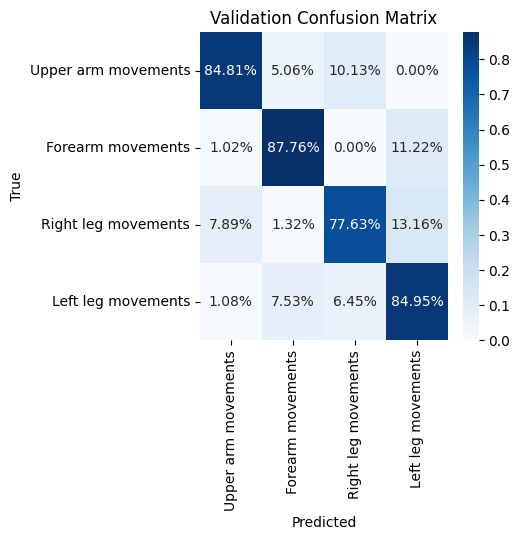

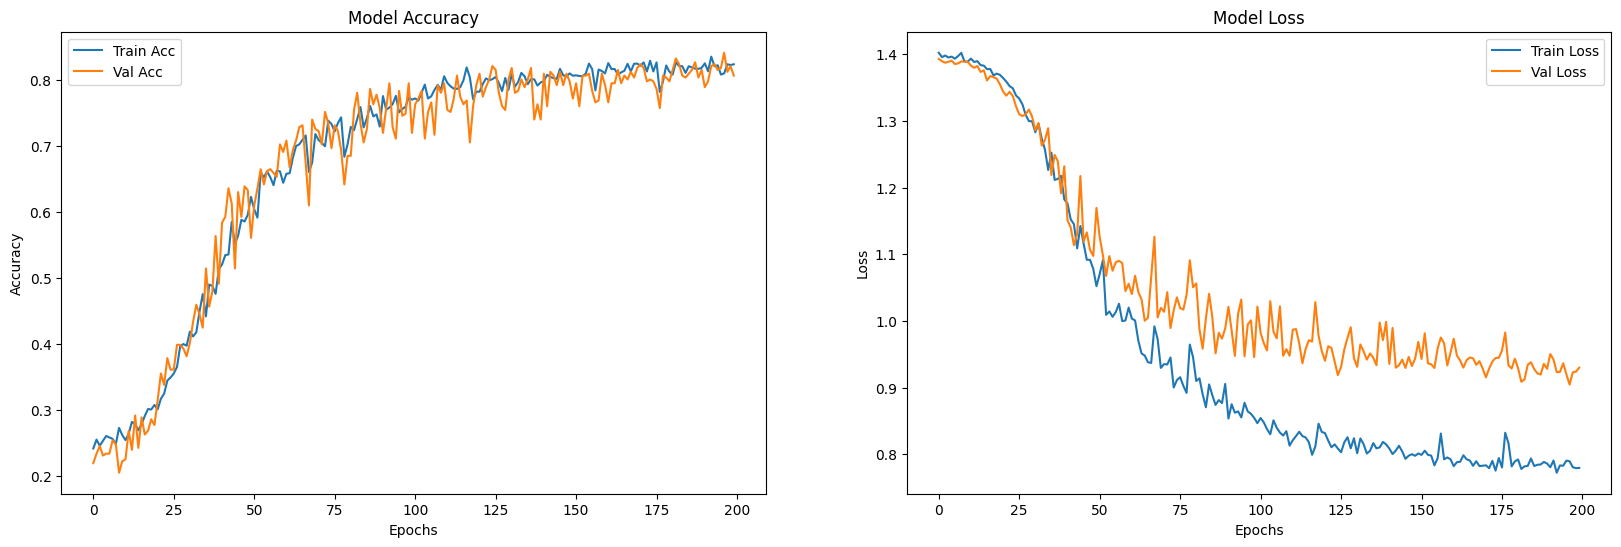

In [35]:
num_epochs = 200
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_acc += compute_accuracy(outputs, labels.float()) * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Evaluation on the validation set
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())

            val_loss += loss.item() * inputs.size(0)
            val_acc += compute_accuracy(outputs, labels) * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Apply custom learning rate decay after each epoch
    current_lr = optimizer.param_groups[0]['lr']
    #print(f"b_lr = {current_lr}")

    optimizer = custom_lr_decay(optimizer)
    #print(f"A_lr = {current_lr}")


    # Print and plot confusion matrix and classification report
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Current LR: {current_lr:.8f}")

# Load the weights of the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model with the best weights on the validation set
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.float())
        all_val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_val_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Print classification report
print("Validation Classification Report:\n", classification_report(all_val_labels, all_val_preds))

# Plotting confusion matrix
conf_mat = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt=".2%", cmap="Blues", xticklabels=class_dir, yticklabels=class_dir)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

# Plotting training and validation accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax = ax.ravel()

ax[0].plot(train_acc_history, label='Train Acc')
ax[0].plot(val_acc_history, label='Val Acc')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_loss_history, label='Train Loss')
ax[1].plot(val_loss_history, label='Val Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [36]:
"""num_epochs = 100

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # Track the best validation accuracy
patience = 7  # Early stopping patience
early_stopping_counter = 0

lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(num_epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_acc += compute_accuracy(outputs, labels.float()) * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Evaluation on the validation set
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())

            val_loss += loss.item() * inputs.size(0)
            val_acc += compute_accuracy(outputs, labels) * inputs.size(0)

            # Collect predictions and true labels for confusion matrix
            all_val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Update learning rate
    lr_schedule.step()

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0  # Reset early stopping counter
    else:
        early_stopping_counter += 1

    # Check for early stopping
    if early_stopping_counter >= patience:
        print(f'Early stopping activated at epoch {epoch+1}.')
        break
    
    # Print and plot confusion matrix and classification report
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(train_loss_history, label='Train Loss')
ax[0].plot(val_loss_history, label='Val Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_acc_history, label='Train Acc')
ax[1].plot(val_acc_history, label='Val Acc')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()"""

'num_epochs = 100\n\ntrain_loss_history = []\ntrain_acc_history = []\nval_loss_history = []\nval_acc_history = []\n\nbest_val_acc = 0.0  # Track the best validation accuracy\npatience = 7  # Early stopping patience\nearly_stopping_counter = 0\n\nlr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)\n\nfor epoch in range(num_epochs):\n    model.train()\n    train_loss, train_acc = 0.0, 0.0\n\n    for inputs, labels in train_loader:\n        inputs, labels = inputs.to(device), labels.to(device)\n\n        optimizer.zero_grad()\n        outputs = model(inputs.float())\n\n        loss = criterion(outputs, labels.float())\n        loss.backward()\n        optimizer.step()\n\n        train_loss += loss.item() * inputs.size(0)\n        train_acc += compute_accuracy(outputs, labels.float()) * inputs.size(0)\n\n    train_loss /= len(train_loader.dataset)\n    train_acc /= len(train_loader.dataset)\n\n    train_loss_history.append(train_loss)\n    train_acc_history.append(tr

/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


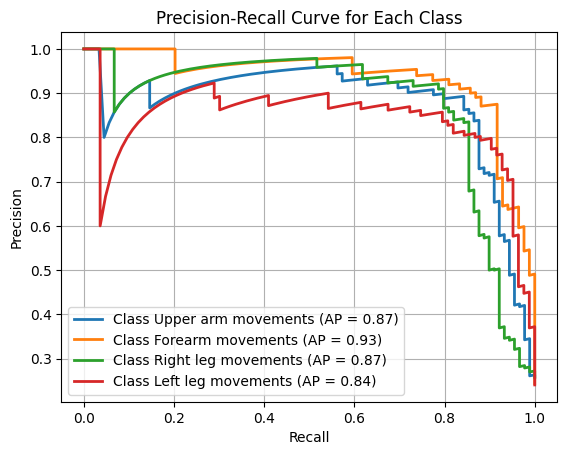

Test Accuracy: 85.22%


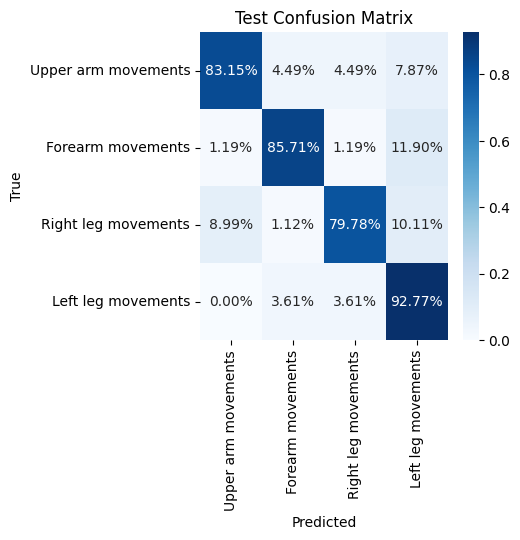

Test Classification Report with Accuracy:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        89
           1       0.90      0.86      0.88        84
           2       0.90      0.80      0.85        89
           3       0.75      0.93      0.83        83

    accuracy                           0.85       345
   macro avg       0.86      0.85      0.85       345
weighted avg       0.86      0.85      0.85       345

Accuracy for each class:
Upper arm movements: 83.15%
Forearm movements: 85.71%
Right leg movements: 79.78%
Left leg movements: 92.77%
Matthews Correlation Coefficient (MCC): 0.8055


In [37]:
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, confusion_matrix

# Set model to evaluation mode
model.eval()

test_predictions = []
true_labels = []
predicted_probs = []  # Store predicted probabilities for PRC

with torch.no_grad():
    for test_data, test_labels in test_loader:
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        
        # Get the output probabilities (not class predictions)
        outputs = model(test_data.float())
        
        # Store the softmax probabilities for PRC (if applicable)
        softmax_probs = torch.softmax(outputs, dim=1)
        predicted_probs.extend(softmax_probs.cpu().numpy())  # Store probabilities for each class
        
        # Get predicted class labels
        _, predicted = torch.max(outputs, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

# Convert predictions, true labels, and predicted probabilities to numpy arrays
test_pred_labels = np.array(test_predictions)
true_test_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Ensure true_test_labels are class indices, not one-hot encoded vectors
if true_test_labels.ndim > 1:
    true_test_labels = np.argmax(true_test_labels, axis=1)

# Precision-Recall Curves for Each Class
n_classes = len(class_dir)  # Assuming class_dir is a list of class names
prc_data = {}  # Dictionary to save precision, recall, and average precision for each class

for i in range(n_classes):
    # Get binary labels for class i (one-vs-rest approach)
    y_true_bin = (true_test_labels == i).astype(int)
    
    # Get predicted probabilities for class i
    y_scores = predicted_probs[:, i]
    
    # Compute Precision-Recall curve and Average Precision
    precision, recall, thresholds = precision_recall_curve(y_true_bin, y_scores)
    avg_precision = average_precision_score(y_true_bin, y_scores)
    
    # Store precision, recall, and thresholds for later
    prc_data[i] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds,
        'avg_precision': avg_precision
    }
    
    # Plot the PRC curve for this class
    plt.plot(recall, precision, lw=2, label=f'Class {class_dir[i]} (AP = {avg_precision:.2f})')

# Add labels and plot settings for PRC
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.grid(True)

# Save PRC plot as PDF
plt.savefig('precision_recall_curves.pdf')
plt.show()



# Existing code for evaluation metrics
# Calculate accuracy for the test set
test_accuracy = accuracy_score(true_test_labels, test_pred_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Generate confusion matrix for the test set
conf_mat_test = confusion_matrix(true_test_labels, test_pred_labels)

# Calculate accuracy values for each class in the confusion matrix
conf_mat_accuracy = conf_mat_test.diagonal() / conf_mat_test.sum(axis=1)
conf_mat_accuracy = np.nan_to_num(conf_mat_accuracy)  # Handle potential division by zero

# Visualize confusion matrix for the test set with counts
plt.figure(figsize=(len(class_dir), len(class_dir)))
sns.heatmap(conf_mat_test / conf_mat_test.sum(axis=1)[:, np.newaxis], annot=True, fmt=".2%", cmap="Blues", xticklabels=class_dir, yticklabels=class_dir)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()

# Print classification report for the test set with accuracy values
print("Test Classification Report with Accuracy:\n", classification_report(true_test_labels, test_pred_labels))

# Print accuracy values for each class
print("Accuracy for each class:")
for i, cls in enumerate(class_dir):
    print(f"{cls}: {conf_mat_accuracy[i] * 100:.2f}%")

# Calculate and print the MCC for the test set
mcc = matthews_corrcoef(true_test_labels, test_pred_labels)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


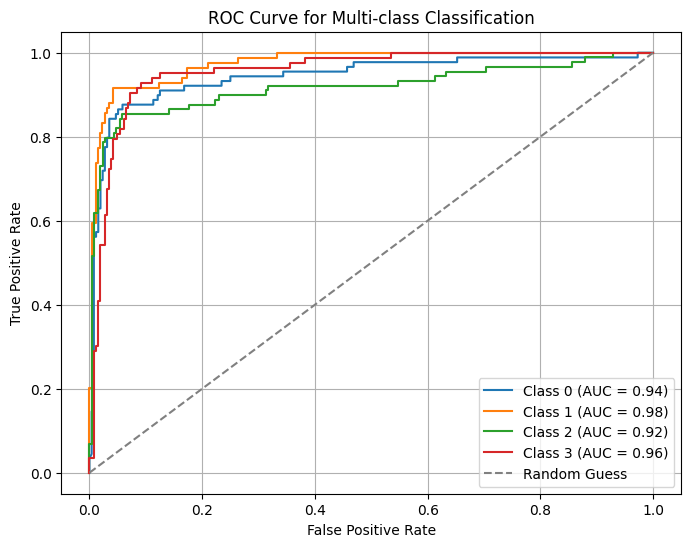

In [38]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Generate predictions for the test set
with torch.no_grad():
    for test_data, test_labels in test_loader:
        test_data = test_data.to(device)
        outputs = model(test_data.float())
        
        # Convert outputs to probabilities using softmax
        probabilities = torch.softmax(outputs, dim=1)
        
        # Append true labels and predicted probabilities
        true_labels.extend(test_labels.cpu().numpy())
        predicted_probs.extend(probabilities.cpu().numpy())

# Convert true labels and predicted probabilities to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Dictionary to store the ROC data
roc_data = {}

# Compute ROC curve and AUC for each class and store them
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Store FPR, TPR, and AUC for the class
    roc_data[f'class_{i}'] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    
    # Plot the ROC curve for the class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.grid()

# Save the plot as a PDF
plt.savefig('roc_curve.pdf')

# Show the plot
plt.show()

In [39]:
"""val_mse = mean_squared_error(val_labels, val_predictions)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_labels, val_predictions)
print(f' Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')"""

"val_mse = mean_squared_error(val_labels, val_predictions)\nval_rmse = np.sqrt(val_mse)\nval_mae = mean_absolute_error(val_labels, val_predictions)\nprint(f' Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')"

In [40]:
# Evaluate the model on the validation set
model.eval()
val_losses = []
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for val_data, val_labels in val_loader:
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        val_outputs = model(val_data.float())
        val_loss = criterion(val_outputs, val_labels)
        val_losses.append(val_loss.item())
        val_predictions.extend(val_outputs.cpu().numpy())
        val_true_labels.extend(val_labels.cpu().numpy())

# Calculate the mean validation loss
mean_val_loss = np.mean(val_losses)

# Convert predictions and true labels to NumPy arrays
val_predictions = np.array(val_predictions)
val_true_labels = np.array(val_true_labels)

# Calculate metrics for the validation set
val_mse = mean_squared_error(val_true_labels, val_predictions)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_true_labels, val_predictions)

# Evaluate the model on the test set
test_predictions = []
true_test_labels = []

with torch.no_grad():
    for test_data, test_labels in test_loader:
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = model(test_data.float())
        test_predictions.extend(test_outputs.cpu().numpy())
        true_test_labels.extend(test_labels.cpu().numpy())

# Convert predictions and true labels to NumPy arrays
test_predictions = np.array(test_predictions)
true_test_labels = np.array(true_test_labels)

# Calculate metrics for the test set
test_mse = mean_squared_error(true_test_labels, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(true_test_labels, test_predictions)

# Print the results
print(f'Validation Loss: {mean_val_loss:.4f}')
print(f'Validation MSE: {val_mse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Validation MAE: {val_mae:.4f}')
print('--------------------')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')


/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


Validation Loss: 0.9055
Validation MSE: 0.0731
Validation RMSE: 0.2704
Validation MAE: 0.0835
--------------------
Test MSE: 0.0673
Test RMSE: 0.2594
Test MAE: 0.0775


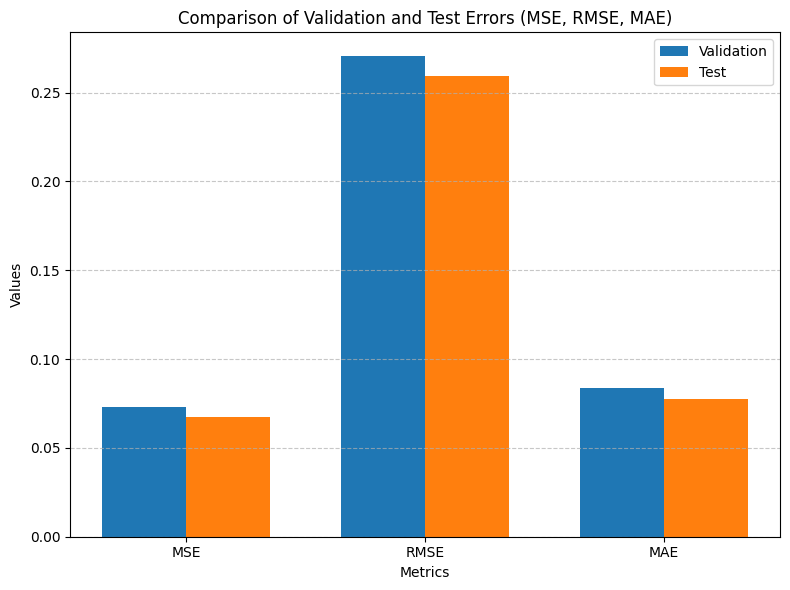

In [41]:
# Metrics (for legend)
metrics = ['MSE', 'RMSE', 'MAE']

# Create a bar graph
plt.figure(figsize=(8, 6))
x = np.arange(len(metrics))  # Positions of bars on x-axis
bar_width = 0.35  # Width of each bar

# Plot validation metrics
val_scores = [val_mse, val_rmse, val_mae]
plt.bar(x - bar_width/2, val_scores, bar_width, label='Validation')

# Plot test metrics (shifted on x-axis for better visibility)
test_scores = [test_mse, test_rmse, test_mae]
plt.bar(x + bar_width/2, test_scores, bar_width, label='Test')

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Validation and Test Errors (MSE, RMSE, MAE)')

# Add legend
plt.legend()

# Show the plot
plt.xticks(x, metrics)  # Align x-axis labels with bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_26/2473474777.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)


Capturing feature maps from conv1
Capturing feature maps from conv2
Capturing feature maps from conv3
Feature maps saved to conv1_feature_maps.pdf


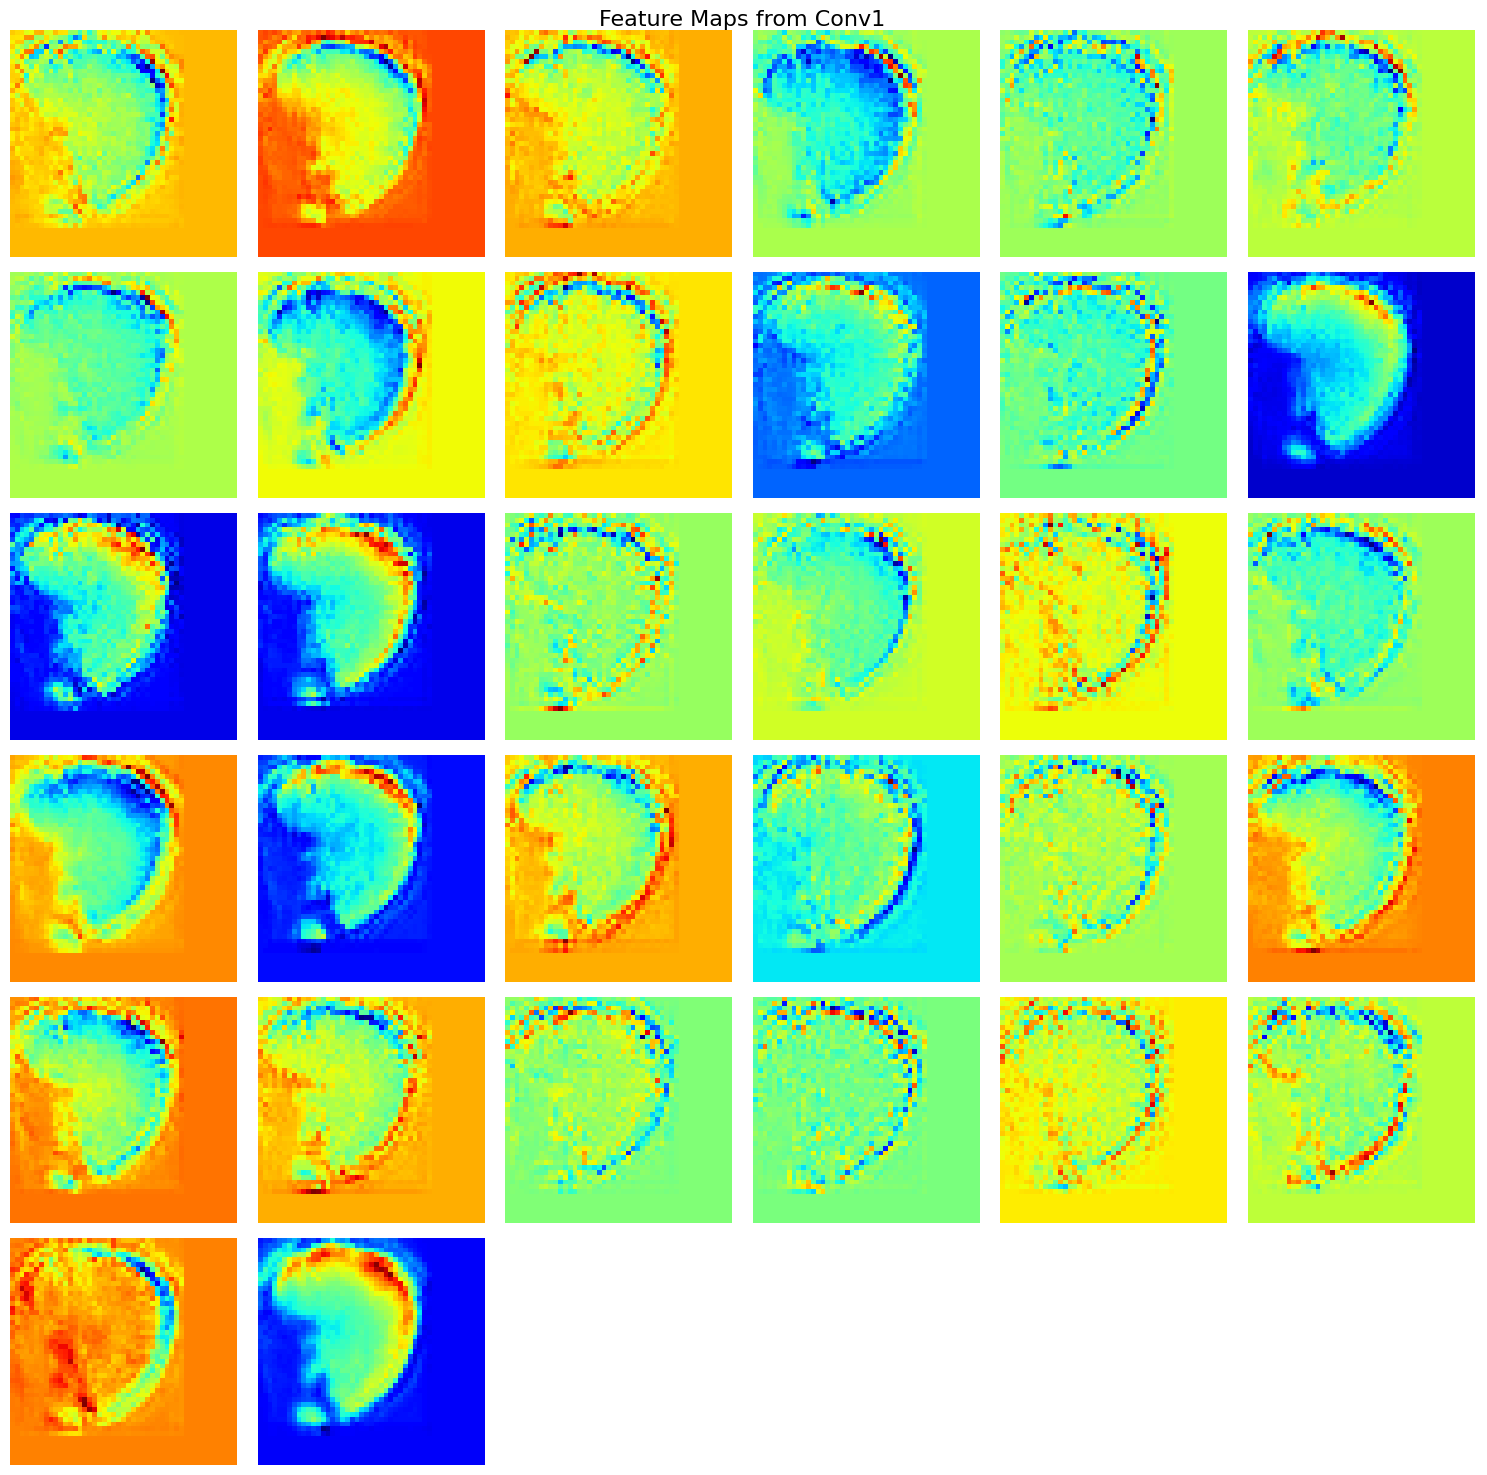

Feature maps saved to conv2_feature_maps.pdf


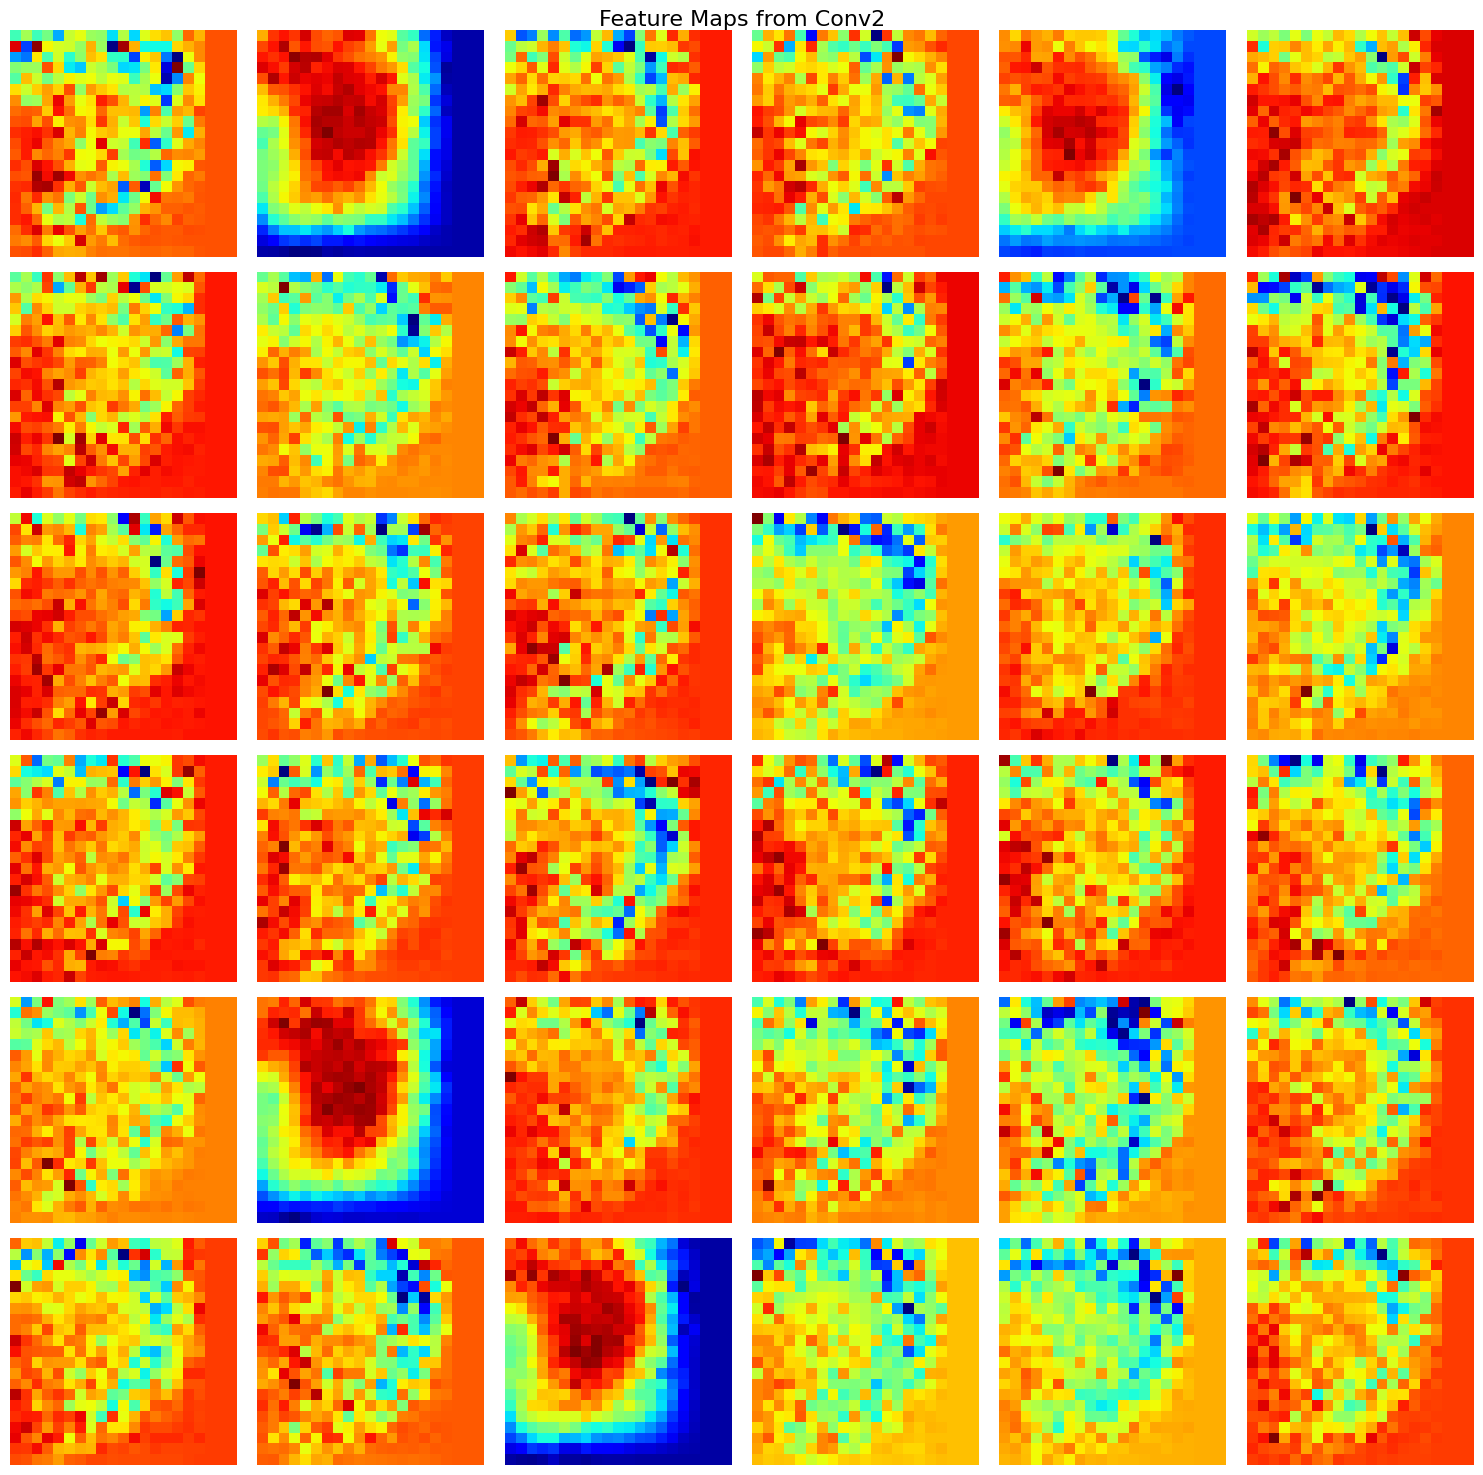

Feature maps saved to conv3_feature_maps.pdf


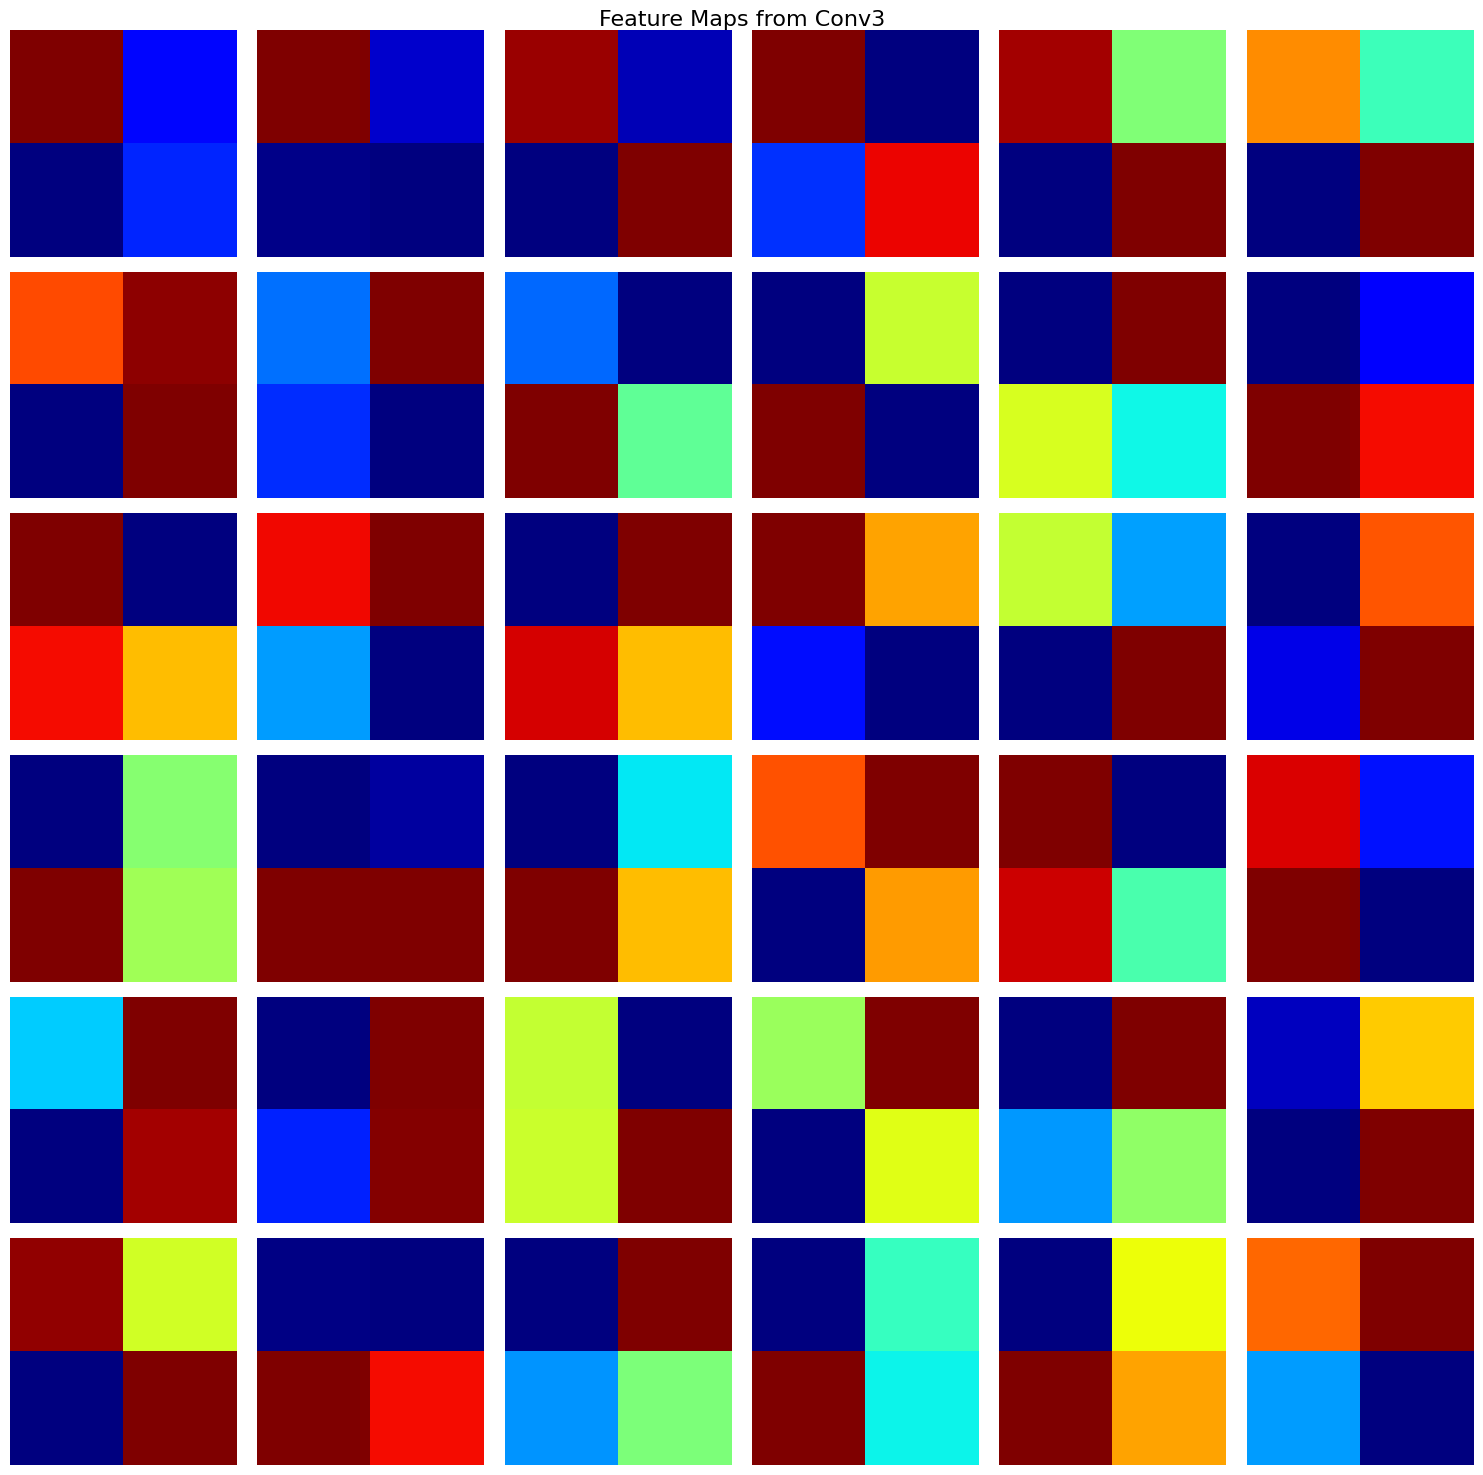

In [42]:
# Initialize dictionary to store feature maps
feature_maps = {}

# Define hook function to capture feature maps
def hook_fn(module, input, output, layer_name):
    print(f"Capturing feature maps from {layer_name}")  # Debugging print statement
    feature_maps[layer_name] = output.detach().cpu()

# Register hooks on the correct layers
model.conv1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, 'conv1'))
model.conv2.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, 'conv2'))
model.conv3.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, 'conv3'))




# Hook function with print statement
def hook_fn(module, input, output, layer_name):
    print(f"Capturing feature maps from {layer_name}")
    feature_maps[layer_name] = output.detach().cpu()

# Capture feature maps from the validation set
model.eval()

# Example forward pass through the model (assuming you have 'val_loader' for validation)
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        # Forward pass through the model (hooks will capture feature maps)
        outputs = model(inputs.float())

        # After the forward pass, feature maps should be captured
        break  # Stop after one batch for visualization


#print(feature_maps.keys())  # Should print: dict_keys(['conv1', 'conv2', 'conv3'])

def visualize_feature_maps(feature_map, layer_name, num_cols=6, max_rows=6, save_as_pdf=False, pdf_filename="feature_maps.pdf"):
    # Determine number of feature maps (channels)
    num_feature_maps = feature_map.size(1)

    # Set up figure for visualization
    num_rows = min(max_rows, (num_feature_maps + num_cols - 1) // num_cols)  # Calculate rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    # Visualize each channel in the feature map
    for idx in range(min(num_feature_maps, num_rows * num_cols)):
        ax = axes[idx]

        # Visualize a 2D slice of the 3D feature map (e.g., the middle slice along depth)
        slice_idx = feature_map.size(2) // 2  # Middle slice in the depth dimension (axis 2)
        feature_slice = feature_map[0, idx, slice_idx, :, :].detach().cpu().numpy()

        ax.imshow(feature_slice, cmap='jet')
        ax.axis('off')

    # Hide any unused subplots
    for idx in range(min(num_feature_maps, num_rows * num_cols), num_rows * num_cols):
        axes[idx].axis('off')

    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    plt.tight_layout()

    # Save to PDF if specified
    if save_as_pdf:
        plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')  # Save the plot as a PDF file
        print(f"Feature maps saved to {pdf_filename}")

    plt.show()

# Example usage for visualizing the captured feature maps
visualize_feature_maps(feature_maps['conv1'], 'Conv1', save_as_pdf=True, pdf_filename='conv1_feature_maps.pdf')
visualize_feature_maps(feature_maps['conv2'], 'Conv2', save_as_pdf=True, pdf_filename='conv2_feature_maps.pdf')
visualize_feature_maps(feature_maps['conv3'], 'Conv3', save_as_pdf=True, pdf_filename='conv3_feature_maps.pdf')

In [43]:
# Define a dictionary to store training history
training_history = {
    'train_loss': train_loss_history,
    'train_acc': train_acc_history,
    'val_loss': val_loss_history,
    'val_acc': val_acc_history,
}

# Save training history
torch.save(training_history, 'training_history.pth')

# Save configuration or hyperparameters
config = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": num_epochs,
    # Add other hyperparameters as needed
}
torch.save(config, 'config.pth')

# Save confusion matrices
torch.save(torch.from_numpy(conf_mat_test), 'confusion_matrix_test.pth')
torch.save(torch.from_numpy(conf_mat), 'confusion_matrix_val.pth')


# Save the ROC data in a .pth file
torch.save(roc_data, 'roc_data.pth')

# Save PRC data (precision, recall, thresholds, avg_precision) for each class in a .pth file
torch.save(prc_data, 'prc_data.pth')

In [44]:
#!kaggle kernels output indrojitsarkar11/fork-of-mri-pytorch-this -p /kaggle/working/load!